## Семинар 13. Гребневая регрессия.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

In [2]:
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### Задача №1

В файле "House_prices_corrected.csv" представлены характеристики различных домов (стоимость, площадь, количество комнат, год постройки и тп, описание признаков можно найти по ссылке [__Ames Housing dataset__](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).

Изучить линейную зависимость стоимости домов (SalePrice) от всех остальных показателей.

In [3]:
data = pd.read_csv('House_prices_corrected.csv')

In [4]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,222264
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,217555
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,270819
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,176732
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,310680


In [5]:
x = data.drop(['SalePrice'], 1)
y = data['SalePrice']

В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [7]:
#lr = LinearRegression()
lr = Ridge() #по умолчанию alpha=1.0, fit_intercept=True
lr.fit(x_train, y_train)

y_hat_test = lr.predict(x_test)
print('Test MSE %.3f' % mean_squared_error(y_test, y_hat_test))
print('Test R2 %.3f' % r2_score(y_test, y_hat_test))

Test MSE 1214481506.599
Test R2 0.792


Для сравнения:

In [8]:
y_hat_train = lr.predict(x_train)
print("Train MSE = %.3f" % mean_squared_error(y_train, y_hat_train))
print("Train R2 = %.3f" % r2_score(y_train, y_hat_train))

Train MSE = 1348178260.344
Train R2 = 0.809


### Шкалирование признаков

Посмотрим на то, какие признаки оказались самыми "сильными". Для этого визуализируем коэффициенты регрессии, соответствующие признакам.

In [9]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2) #ncols=2: два графика (два столбца)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True) #сортировка по весам по убыванию
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

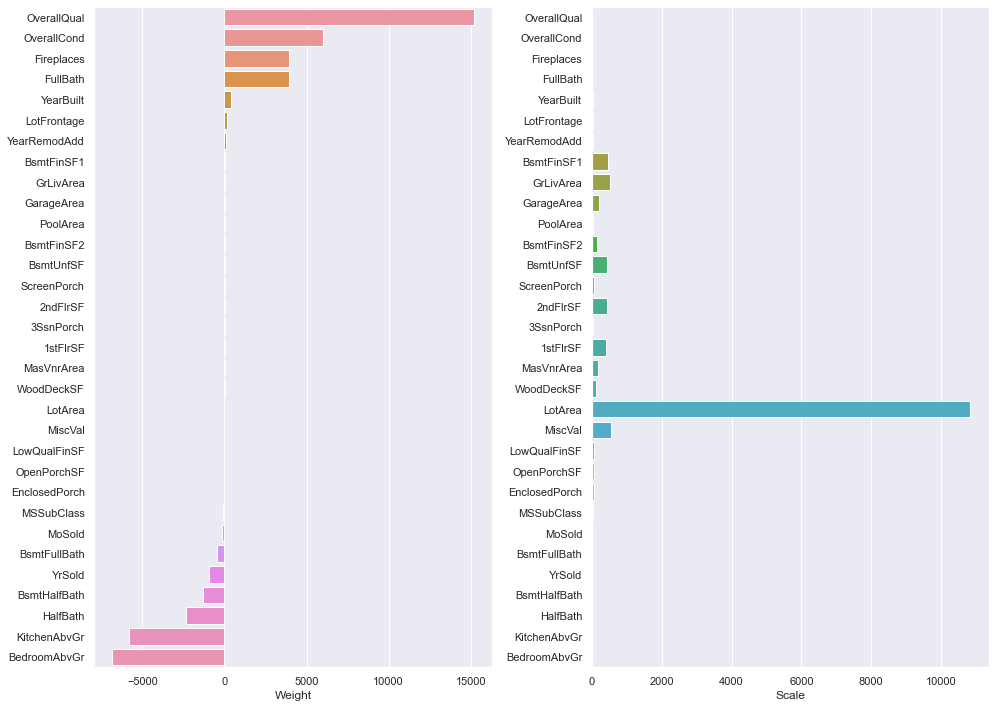

In [10]:
show_weights(x_train.columns, lr.coef_, x_train.std())

Будем масштабировать наши признаки. Это сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [11]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) #на test делаем только transform!

lr = Ridge()
lr.fit(x_train_scaled, y_train)

Ridge()

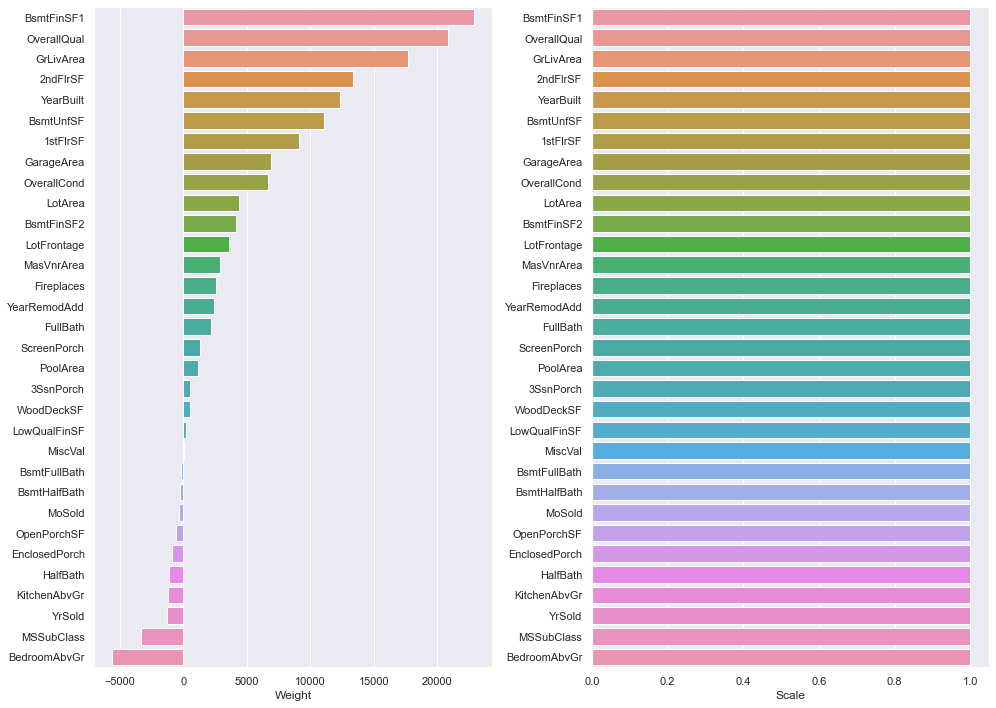

In [12]:
show_weights(x_train.columns, lr.coef_, x_train_scaled.std(axis=0)) #type(x_train_scaled) = numpy.ndarray

### Подбор гиперпараметров

Наряду с параметрами, которые модель оптимизирует на этапе обучения (коэффициенты регрессии), у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. 

Будем пользоваться кросс-валидацией для подбора гиперпараметров.

Подберем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины.

Best alpha = 162.3777


Text(0, 0.5, 'CV score')

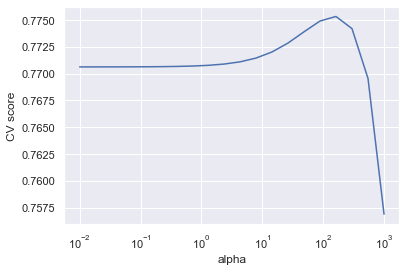

In [14]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="r2", cv=10)
searcher.fit(x_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [15]:
lr = Ridge(best_alpha) 
lr.fit(x_train_scaled, y_train)

y_hat_test = lr.predict(x_test_scaled)
print('Test MSE %.3f' % mean_squared_error(y_test, y_hat_test))
print('Test R2 %.3f' % r2_score(y_test, y_hat_test))

Test MSE 1161580563.154
Test R2 0.801


In [16]:
lr.intercept_

183187.74058219188

In [17]:
lr = Ridge() 
lr.fit(x_train_scaled, y_train)

y_hat_test = lr.predict(x_test_scaled)
print('Test MSE %.3f' % mean_squared_error(y_test, y_hat_test))
print('Test R2 %.3f' % r2_score(y_test, y_hat_test))

Test MSE 1213457678.008
Test R2 0.792


In [18]:
lr.intercept_ #обратим внимание на то, что константа в регрессии не регуляризуется

183187.7405821919